# Local Neighbourhoods

This notebook uses single-link clustering to find very local neighbourhoods based on low cosine distance thresholds (see https://github.com/meedan/temporal_clustering).

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns
from src.viz.plot_config import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set seed
np.random.seed(42)


# Set data path
PROJECT_ROOT = find_project_root()
CLUSTER_PATH = f"{PROJECT_ROOT}/results/clusters"
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/cluster_plots"
ensure_dir_exists(PLOT_PATH)


# Load data
data_dict = load_data(PROJECT_ROOT, models=False, metadata=False)
# Unpack dictionary
for key, dataset in data_dict.items():
    # Unnest the survey columns for ease of analysis
    if key == "survey":
        nested_columns = ["location", "religion", "ethnicity"]
        dataset = unnest_columns(dataset, nested_columns)
        data_dict[key] = dataset
    # Inspect each dataset
    print(f"{key}: {dataset.shape}")
    display(dataset.head(2))
    print("\n")

survey: (1500, 48)


,user_id,survey_only,num_completed_conversations,timing_duration_s,timing_duration_mins,generated_datetime,consent,consent_age,lm_familiarity,lm_indirect_use,...,location_reside_subregion,location_reside_countryISO,location_same_birth_reside_country,location_special_region,religion_self_described,religion_categorised,religion_simplified,ethnicity_self_described,ethnicity_categorised,ethnicity_simplified
0,user0,False,1,266,4.43,2023-11-22 15:48:46,"Yes, I consent to take part",I certify that I am 18 years of age or over,Somewhat familiar,Yes,...,Northern America,CAN,Yes,Northern America,prefer not to say,Prefer not to say,Prefer not to say,prefer not to say,Prefer not to say,Prefer not to say
1,user1,False,6,632,10.53,2023-11-22 15:56:10,"Yes, I consent to take part",I certify that I am 18 years of age or over,Somewhat familiar,Yes,...,Northern America,CAN,Yes,Northern America,prefer not to say,Prefer not to say,Prefer not to say,caucasian,White,White




conversations: (8011, 13)


,conversation_id,user_id,included_in_balanced_subset,generated_datetime,timing_duration_s,timing_duration_mins,conversation_type,opening_prompt,conversation_turns,conversation_history,performance_attributes,choice_attributes,open_feedback
0,c0,user0,False,2023-11-22 15:55:46,401.07,6.68,unguided,What can you do about the inequality of wealth?,5,"[{'turn': 0, 'role': 'user', 'content': 'What ...","{'values': None, 'fluency': 95, 'factuality': ...","{'values': None, 'fluency': 80, 'factuality': ...",Shorter blocks would be nice. but has to ha...
1,c1,user1,True,2023-11-22 16:07:49,642.97,10.72,unguided,What can I do to start making extra money on t...,2,"[{'turn': 0, 'role': 'user', 'content': 'What ...","{'values': 50, 'fluency': 100, 'factuality': 1...","{'values': 50, 'fluency': 100, 'factuality': 1...",The first time I responded to the second quest...




utterances: (68371, 14)


,utterance_id,interaction_id,conversation_id,user_id,turn,within_turn_id,included_in_balanced_subset,conversation_type,user_prompt,model_response,model_name,model_provider,score,if_chosen
0,ut0,int0,c0,user0,0,0,False,unguided,What can you do about the inequality of wealth?,Make it illegal for corporations to own a majo...,google/flan-t5-xxl,huggingface_api,17,False
1,ut1,int0,c0,user0,0,1,False,unguided,What can you do about the inequality of wealth?,"As an AI language model, I cannot express pers...",command-light,cohere,92,True


## Load Clusters

In [2]:
# Find all files in {CLUSTER_PATH} beginning with local_cluster
local_cluster_files = [
    f for f in os.listdir(CLUSTER_PATH) if f.startswith("local_clusters_opening_prompt")
]
thresholds = [
    float(f.split("_")[-1].split(".")[0].replace("-", ".")) for f in local_cluster_files
]
# Load them
local_clusters = [pd.read_csv(f"{CLUSTER_PATH}/{f}") for f in local_cluster_files]

# Turn into a dictionary with threshold as key
local_clusters_dict = dict(zip(thresholds, local_clusters))

# Sort keys of dictionary
local_clusters_dict = dict(sorted(local_clusters_dict.items()))

In [3]:
local_clusters_dict.keys()

dict_keys([0.05, 0.125, 0.2])

## Examine Clusters

In [4]:
# Plot cluster size distribution
for threshold, df in local_clusters_dict.items():

    print("\n###############")
    print(f"Threshold: {threshold}")
    # Prelims
    print(f"Number of prompts: {df.shape[0]}")
    print(f'Number of unique convo ids: {df["conversation_id"].nunique()}')
    print(f'Number of unique user ids: {df["user_id"].nunique()}')

    # Unique clusters
    nunique_clusters = df["cluster_membership"].nunique()
    print(f"Unique clusters: {nunique_clusters}")
    # Singleton clusters
    cluster_sizes = df["cluster_membership"].value_counts()
    singletons = cluster_sizes[cluster_sizes == 1].index
    print(f"Singleton clusters: {len(singletons)}")
    # Non-singleton clusters
    non_singletons = cluster_sizes[cluster_sizes > 1].index
    non_singleton_df = df[df["cluster_membership"].isin(non_singletons)]

    # Group by cluster member and see if there are duplicate user ids
    has_duplicates = 0
    pct_dup_array = []
    for cluster in non_singleton_df["cluster_membership"].unique():
        prompts = non_singleton_df[non_singleton_df["cluster_membership"] == cluster]
        users = prompts["user_id"].unique()
        # Find number of duplicates
        n_duplicates = len(prompts) - len(users)
        if n_duplicates > 0:
            has_duplicates += 1
        # Percentage duplicated
        pct_dup = np.round(n_duplicates / len(prompts) * 100, 2)
        pct_dup_array.append(pct_dup)

    print(f"Non-singleton clusters: {len(non_singletons)}")
    print(
        f"Number of clusters with duplicate userIDs: {has_duplicates} ({np.round(has_duplicates/len(non_singletons)*100, 2)}%)"
    )
    print(f"Average of duplicates: ({np.round(np.mean(pct_dup_array), 2)}%)")
    # Size distribution
    print("Cluster size distribution (non-singleton):")
    print(non_singleton_df["cluster_membership"].value_counts().describe())


###############
Threshold: 0.05
Number of prompts: 8011
Number of unique convo ids: 8011
Number of unique user ids: 1396
Unique clusters: 7588
Singleton clusters: 7424
Non-singleton clusters: 164
Number of clusters with duplicate userIDs: 15 (9.15%)
Average of duplicates: (4.04%)
Cluster size distribution (non-singleton):
count    164.000000
mean       3.579268
std        5.654668
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       60.000000
Name: count, dtype: float64

###############
Threshold: 0.125
Number of prompts: 8011
Number of unique convo ids: 8011
Number of unique user ids: 1396
Unique clusters: 7240
Singleton clusters: 6955
Non-singleton clusters: 285
Number of clusters with duplicate userIDs: 19 (6.67%)
Average of duplicates: (2.73%)
Cluster size distribution (non-singleton):
count    285.000000
mean       3.705263
std        5.615384
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       62.000000
N

In [5]:
# Merge so that for each row we have their assignment for each threshold
for threshold, df in local_clusters_dict.items():
    df = df.rename(columns={"cluster_membership": f"cluster_membership_{threshold}"})
    local_clusters_dict[threshold] = df
df = pd.concat(local_clusters_dict.values(), axis=1)
# Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
df.head(2)

,conversation_id,user_id,cluster_membership_0.05,cluster_membership_0.125,cluster_membership_0.2
0,c4325,user788,0,0,0
1,c7777,user1405,1,1,1


## Matching with other data

### Topical Clusters

In [6]:
prompt_df = pd.read_csv(f"{CLUSTER_PATH}/opening_prompt_text_df_original.csv")
cluster_metadata = pd.read_csv(f"{CLUSTER_PATH}/opening_prompt_cluster_df_original.csv")
keep_cols = ["id", "cluster_id"]
prompt_df = prompt_df[keep_cols]
prompt_df = prompt_df.rename(columns={"id": "conversation_id"})
# Merge metadata
topic_df = prompt_df.merge(
    cluster_metadata[["cluster_id", "gpt_description"]], on="cluster_id", how="left"
)
# Replace "" in cluster name)
topic_df["gpt_description"] = topic_df["gpt_description"].map(
    lambda x: x.replace('"', "")
)
display(topic_df.head(2))
print(topic_df.shape)

,conversation_id,cluster_id,gpt_description
0,c0,12,Economic Policy and Income Inequality
1,c1,18,Job Search


(8011, 3)


In [7]:
df = df.merge(topic_df, on="conversation_id", how="left")
display(df.head(2))
print(df.shape)

,conversation_id,user_id,cluster_membership_0.05,cluster_membership_0.125,cluster_membership_0.2,cluster_id,gpt_description
0,c4325,user788,0,0,0,-1,Outliers
1,c7777,user1405,1,1,1,-1,Outliers


(8011, 7)


### Match Demographics of Authors

In [8]:
demo_attributes = [
    "gender",
    "age",
    "ethnicity_simplified",
    "religion_simplified",
    "location_special_region",
]

id_attributes = ["cluster_id", "user_id"]

local_cluster_assignments = [c for c in df.columns if "cluster_membership" in c]
cols_of_interest = (
    [
        "opening_prompt",
        "gpt_description",
    ]
    + demo_attributes
    + id_attributes
    + local_cluster_assignments
)

In [9]:
conversations = data_dict["conversations"]
survey = data_dict["survey"]
# Merge with survey
conversations = conversations.merge(survey, on="user_id", how="left")

# Now merge with the cluster assignments to get our local neighbourhood df
df = df.merge(conversations, on=["conversation_id", "user_id"], how="left")

In [10]:
# Keep only the columns of interest
df = df[cols_of_interest]
display(df.head(2))
print(df.shape)
print(df.columns)

,opening_prompt,gpt_description,gender,age,ethnicity_simplified,religion_simplified,location_special_region,cluster_id,user_id,cluster_membership_0.05,cluster_membership_0.125,cluster_membership_0.2
0,1973,Outliers,Female,25-34 years old,White,No Affiliation,UK,-1,user788,0,0,0
1,9/11 was an inside job because there was no re...,Outliers,Female,55-64 years old,White,Christian,US,-1,user1405,1,1,1


(8011, 12)
Index(['opening_prompt', 'gpt_description', 'gender', 'age',
       'ethnicity_simplified', 'religion_simplified',
       'location_special_region', 'cluster_id', 'user_id',
       'cluster_membership_0.05', 'cluster_membership_0.125',
       'cluster_membership_0.2'],
      dtype='object')


## Inspect Clusters

In [11]:
non_singleton_ids = {}
for threshold, thresh_df in local_clusters_dict.items():
    cluster_sizes = thresh_df[f"cluster_membership_{threshold}"].value_counts()
    non_singletons = cluster_sizes[cluster_sizes > 1].index
    non_singleton_ids[threshold] = non_singletons

### Random (No Cherry Picking!)

In [12]:
# Pick some random clusters to inspect (no cherry picking!)
for threshold in sorted(thresholds):
    print("\n###############")
    print(f"Threshold: {threshold}")
    non_singletons_all = non_singleton_ids[threshold]
    print(f"Number of non-singletons: {len(non_singletons_all)}")
    # Set seed for reproducibility
    np.random.seed(42)
    # Sample some random clusters
    non_singletons = np.random.choice(non_singletons_all, 5)
    for cluster_id in non_singletons:
        print(f"\nCluster ID: {cluster_id}")
        cluster_df = df[df[f"cluster_membership_{threshold}"] == cluster_id]
        print(f"Size of cluster: {cluster_df.shape[0]}")
        # Only show top 10
        print(cluster_df["opening_prompt"].value_counts()[0:10])
        print(cluster_df["gpt_description"].value_counts())
        display(cluster_df[demo_attributes + ["user_id"]].describe())


###############
Threshold: 0.05
Number of non-singletons: 164

Cluster ID: 4433
Size of cluster: 2
opening_prompt
What are your thoughts on the HAMAS situation currently.    1
What is your take on the Hamas situation?                   1
Name: count, dtype: int64
gpt_description
Israel-Palestine Conflict    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,1,2,1,2,2,2
top,Male,18-24 years old,White,No Affiliation,Australia and New Zealand,user1055
freq,2,1,2,1,1,1



Cluster ID: 4579
Size of cluster: 2
opening_prompt
What do you think about Taylor Swift?    1
What do you think of Taylor Swift?       1
Name: count, dtype: int64
gpt_description
Popular Culture (Sports, Music, TV)    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,2,2,2,1,2,2
top,Male,18-24 years old,Hispanic,No Affiliation,Latin America and the Caribbean,user509
freq,1,1,1,2,1,1



Cluster ID: 516
Size of cluster: 6
opening_prompt
Do aliens exist               2
do you think aliens exist?    2
Do aliens exist?              1
do aliens exist               1
Name: count, dtype: int64
gpt_description
Outliers    6
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,6,6,6,6,6,6
unique,2,3,3,3,4,6
top,Male,35-44 years old,White,No Affiliation,UK,user941
freq,4,3,4,4,2,1



Cluster ID: 673
Size of cluster: 2
opening_prompt
Do you think God is real?    1
do you think god is real?    1
Name: count, dtype: int64
gpt_description
Religion and Spirituality    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,2,2,2,2,2,2
top,Female,35-44 years old,White,No Affiliation,Africa,user1049
freq,1,1,1,1,1,1



Cluster ID: 512
Size of cluster: 2
opening_prompt
Do Palestines deserve to be free?     1
Does Palestine deserve to be free?    1
Name: count, dtype: int64
gpt_description
Israel-Palestine Conflict    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,2,1,2,2,2,2
top,Male,18-24 years old,Black,Christian,Africa,user218
freq,1,2,1,1,1,1



###############
Threshold: 0.125
Number of non-singletons: 285

Cluster ID: 5410
Size of cluster: 3
opening_prompt
Who caused the invasion of Ukraine by Russia?    1
Who instigated the war in the Ukraine?           1
who started the ukraine russian war?             1
Name: count, dtype: int64
gpt_description
Global War Discussions    3
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,3,3,3,3,3,3
unique,1,3,2,2,2,3
top,Male,65+ years old,Hispanic,No Affiliation,Latin America and the Caribbean,user1469
freq,3,1,2,2,2,1



Cluster ID: 1833
Size of cluster: 2
opening_prompt
How many genders are there?    1
How many genders exist?        1
Name: count, dtype: int64
gpt_description
Gender and LGBTQ+ Identity    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,1,2,1,2,2,2
top,Female,55-64 years old,White,Christian,Africa,user245
freq,2,1,2,1,1,1



Cluster ID: 2918
Size of cluster: 2
opening_prompt
In how many states is abortion currently legal without restrictions?    1
What states is abortion still legal in?                                 1
Name: count, dtype: int64
gpt_description
Discussions on Abortion    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,2,2,2,2,1,2
top,Female,55-64 years old,Asian,Christian,US,user1485
freq,1,1,1,1,2,1



Cluster ID: 1259
Size of cluster: 3
opening_prompt
Hey    2
hey    1
Name: count, dtype: int64
gpt_description
Greeting Introductions    3
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,3,3,3,3,3,3
unique,1,3,2,2,3,3
top,Male,18-24 years old,White,Christian,Europe,user271
freq,3,1,2,2,1,1



Cluster ID: 3968
Size of cluster: 2
opening_prompt
The debate around GMO in food production. what are your thoughts    1
whats your view on GMOs on food production?                         1
Name: count, dtype: int64
gpt_description
Outliers    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,2,2,1,1,1,2
top,Male,55-64 years old,White,Christian,US,user1430
freq,1,1,2,2,2,1



###############
Threshold: 0.2
Number of non-singletons: 436

Cluster ID: 1359
Size of cluster: 3
opening_prompt
Hi, what do you know about God?    1
What do you think of god?          1
what do you think about god?       1
Name: count, dtype: int64
gpt_description
Religion and Spirituality    3
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,3,3,3,3,3,3
unique,2,3,1,2,3,3
top,Male,55-64 years old,White,No Affiliation,UK,user1239
freq,2,1,3,2,1,1



Cluster ID: 3507
Size of cluster: 2
opening_prompt
Should alcohol be outlawed?            1
should alcohol be banned in the uk?    1
Name: count, dtype: int64
gpt_description
Outliers    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,1,2,1,1,1,2
top,Male,35-44 years old,White,No Affiliation,UK,user504
freq,2,1,2,2,2,1



Cluster ID: 1655
Size of cluster: 2
opening_prompt
How do you make an apple pie?    1
how to make a pie                1
Name: count, dtype: int64
gpt_description
Recipe and Cooking Queries    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,2,1,2,2,2,2
top,Female,35-44 years old,Black,Christian,US,user672
freq,1,2,1,1,1,1



Cluster ID: 1174
Size of cluster: 2
opening_prompt
Hello. Can you tell me what is glaucoma?    1
what is glaucoma                            1
Name: count, dtype: int64
gpt_description
Outliers    2
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,2,2,2,2,2,2
unique,1,1,1,1,1,1
top,Female,45-54 years old,White,No Affiliation,Europe,user932
freq,2,2,2,2,2,2



Cluster ID: 961
Size of cluster: 3
opening_prompt
Gay people should be allowed to get married.    1
Gay people shouldn't get married.               1
Gays should not marry.                          1
Name: count, dtype: int64
gpt_description
Gender and LGBTQ+ Identity    3
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,3,3,3,3,3,3
unique,2,3,1,1,2,3
top,Female,25-34 years old,White,No Affiliation,Europe,user455
freq,2,1,3,3,2,1


### Biggest clusters

In [13]:
MAX_CLUSTER_SIZE = 0
for threshold in sorted(thresholds):
    print("\n###############")
    print(f"Threshold: {threshold}")
    non_singletons_all = non_singleton_ids[threshold]
    print(f"Number of non-singletons: {len(non_singletons_all)}")
    # Find the biggest clusters
    cluster_sizes = df[f"cluster_membership_{threshold}"].value_counts()
    biggest_clusters = cluster_sizes[cluster_sizes > 1].index
    biggest_clusters = biggest_clusters[:5]
    # If biggest cluster is bigger than MAX_CLUSTER_SIZE, update
    if cluster_sizes[biggest_clusters[0]] > MAX_CLUSTER_SIZE:
        MAX_CLUSTER_SIZE = cluster_sizes[biggest_clusters[0]]
    for cluster_id in biggest_clusters:
        print(f"\nCluster ID: {cluster_id}")
        cluster_df = df[df[f"cluster_membership_{threshold}"] == cluster_id]
        print(f"Size of cluster: {cluster_df.shape[0]}")
        print(cluster_df["opening_prompt"].value_counts()[0:10])
        print(cluster_df["gpt_description"].value_counts())
        display(cluster_df[demo_attributes + ["user_id"]].describe())


###############
Threshold: 0.05
Number of non-singletons: 164

Cluster ID: 1129
Size of cluster: 60
opening_prompt
Hello    36
hello    24
Name: count, dtype: int64
gpt_description
Outliers    60
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,60,60,60,60,60,60
unique,2,5,5,5,8,35
top,Female,25-34 years old,White,Christian,Latin America and the Caribbean,user764
freq,32,20,29,28,19,6



Cluster ID: 1130
Size of cluster: 34
opening_prompt
Hi, how are you?          9
Hello, how are you?       7
Hello how are you?        3
hi, how are you?          2
Hello ! How are you ?     1
Hi, How are you?          1
hello. how are you?       1
hello how are you?        1
Hi, how are you doing?    1
Hi how are you ?          1
Name: count, dtype: int64
gpt_description
Greeting Introductions    34
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,34,34,34,34,34,34
unique,2,5,7,4,8,33
top,Female,25-34 years old,White,No Affiliation,Europe,user168
freq,21,16,19,25,11,2



Cluster ID: 1337
Size of cluster: 21
opening_prompt
Hi    12
hi     9
Name: count, dtype: int64
gpt_description
Outliers    21
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,21,21,21,21,21,21
unique,2,5,6,5,6,15
top,Male,25-34 years old,White,No Affiliation,Latin America and the Caribbean,user1181
freq,13,9,11,8,8,4



Cluster ID: 508
Size of cluster: 14
opening_prompt
Does God exist?    6
does god exist?    4
Do God exist?      1
Does god exist?    1
does God exist?    1
does god exist     1
Name: count, dtype: int64
gpt_description
Outliers    14
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,14,14,14,14,14,14
unique,2,4,5,3,8,14
top,Female,35-44 years old,White,No Affiliation,UK,user6
freq,9,5,9,7,4,1



Cluster ID: 4177
Size of cluster: 14
opening_prompt
What do you think about abortion?       5
WHat do you think about abortion        1
What are your thoughts on abortion      1
What are your thoughts on abortion ?    1
What are your thoughts on abortion?     1
What is your opinion on abortion?       1
What is your take on abortion?          1
what do you think about abortion?       1
what is your opinion of abortion        1
whats your view on abortion             1
Name: count, dtype: int64
gpt_description
Discussions on Abortion    14
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,14,14,14,14,14,14
unique,2,5,4,2,5,14
top,Male,25-34 years old,White,No Affiliation,Latin America and the Caribbean,user560
freq,9,8,6,10,7,1



###############
Threshold: 0.125
Number of non-singletons: 285

Cluster ID: 1105
Size of cluster: 62
opening_prompt
Hello     36
hello     24
Hello.     2
Name: count, dtype: int64
gpt_description
Outliers    62
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,62,62,62,62,62,62
unique,2,5,5,5,9,36
top,Female,25-34 years old,White,Christian,Latin America and the Caribbean,user764
freq,33,20,30,28,19,6



Cluster ID: 1106
Size of cluster: 51
opening_prompt
Hi, how are you?          9
Hello, how are you?       7
How are you?              6
Hello how are you?        3
hi, how are you?          2
How are you doing?        2
Hello ! How are you ?     1
Hi, how are you doing?    1
how are you               1
hi,how are you            1
Name: count, dtype: int64
gpt_description
Greeting Introductions    51
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,51,51,51,51,51,51
unique,3,5,7,6,8,50
top,Female,25-34 years old,White,No Affiliation,Europe,user168
freq,28,22,28,34,18,2



Cluster ID: 1108
Size of cluster: 30
opening_prompt
How are you today?            8
how are you today?            2
Hello, how was your day?      2
How are you doing today?      2
Hi, how are you today?        2
Hello - how are you today?    1
Hi, How are you today ?       1
hi, how has your day been?    1
How is your day               1
How are you feeling today?    1
Name: count, dtype: int64
gpt_description
Greeting Introductions    30
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,30,30,30,30,30,30
unique,2,6,5,3,9,30
top,Female,35-44 years old,White,No Affiliation,US,user1479
freq,18,10,24,17,10,1



Cluster ID: 1293
Size of cluster: 23
opening_prompt
Hey, what do you think about the israeli-palestinian conflict?       1
What is your opinion on the current Israel-Palestine conflict        1
what do you think about the war between israel and palestine?        1
what do you think about the palestine and israel conflict            1
what do you think about the israel and palestine conflict            1
what are your thoughts on israel vs palestine                        1
what are your thoughts about the Palestine and Jerusalem conflict    1
hi, what do you think about the war in israel?                       1
Where do you stand on the current conflict in Israel/Palestine?      1
Where do you stand on the Israel/Palestine conflict?                 1
Name: count, dtype: int64
gpt_description
Israel-Palestine Conflict    23
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,23,23,23,23,23,23
unique,2,5,6,4,9,23
top,Female,25-34 years old,White,No Affiliation,Europe,user1154
freq,14,9,12,13,5,1



Cluster ID: 1298
Size of cluster: 22
opening_prompt
Hi     12
hi      9
hi.     1
Name: count, dtype: int64
gpt_description
Outliers    22
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,22,22,22,22,22,22
unique,2,5,6,5,6,16
top,Male,25-34 years old,White,No Affiliation,Latin America and the Caribbean,user1181
freq,13,9,11,9,9,4



###############
Threshold: 0.2
Number of non-singletons: 436

Cluster ID: 1057
Size of cluster: 98
opening_prompt
Hello     36
hello     24
Hi        12
hi         9
Hello!     6
Hi!        4
Hi,        3
Hello.     2
hi!        1
hi.        1
Name: count, dtype: int64
gpt_description
Outliers    98
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,98,98,98,98,98,98
unique,2,6,7,5,9,59
top,Female,25-34 years old,White,No Affiliation,Latin America and the Caribbean,user764
freq,53,35,51,40,31,6



Cluster ID: 1001
Size of cluster: 87
opening_prompt
Hi, how are you?            9
How are you today?          8
Hello, how are you?         7
How are you?                6
Hello how are you?          3
Hello, how was your day?    2
how are you today?          2
Hi, how are you today?      2
hi, how are you?            2
How are you doing today?    2
Name: count, dtype: int64
gpt_description
Greeting Introductions    87
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,87,87,87,87,87,87
unique,3,6,7,6,9,85
top,Female,25-34 years old,White,No Affiliation,Europe,user168
freq,49,31,56,54,26,2



Cluster ID: 1050
Size of cluster: 60
opening_prompt
What do you think about the current situation in Gaza?                                                              2
Have you heard about what is going on in Palestine? What are your thoughts on Israel and their "war" with Hamas?    1
What do you think about the war between Palestine and Israel                                                        1
What do you think about what's happening in Gaza right now? Mad, isn't it?                                          1
What do you think of the Israel/Palestine conflict                                                                  1
What do you think of the current Middle East conflict?                                                              1
What is your opinion on the Israel-Hamas war?                                                                       1
What is your opinion on the controversy regarding palestine and israel?                                             1
Wha

,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,60,60,60,60,60,60
unique,3,6,7,6,9,60
top,Male,25-34 years old,White,No Affiliation,Europe,user1281
freq,30,23,36,34,15,1



Cluster ID: 258
Size of cluster: 50
opening_prompt
Can we talk a little but about the war between Israeal and Palestine?       1
Write me a review about the crisis between Israel and Palestine nowadays    1
What is happening in gaza right now                                         1
What is happening in the Gaza Strip?                                        1
What is happening in the Gaza strip reight now?                             1
What is happening in the gaza stripe right now?                             1
What is happening with Israel and Palestine                                 1
What is hidden between Israel/Hamas war                                     1
What is known about the current Israel-Hamas struggle in Gaza?              1
What is the lastest on the Israeli Hamas war?                               1
Name: count, dtype: int64
gpt_description
Israel-Palestine Conflict    50
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,50,50,50,50,50,50
unique,3,6,6,5,9,49
top,Female,25-34 years old,White,No Affiliation,Europe,user902
freq,27,19,33,27,11,2



Cluster ID: 495
Size of cluster: 50
opening_prompt
Does God exist?                        6
Do you believe in God?                 5
does god exist?                        4
Do you believe in god?                 2
Do you think that God exists?          2
do you believe in god?                 2
Do God exist?                          1
do you believe that there is a god?    1
Is there a god                         1
Is there a god?                        1
Name: count, dtype: int64
gpt_description
Religion and Spirituality    33
Outliers                     17
Name: count, dtype: int64


,gender,age,ethnicity_simplified,religion_simplified,location_special_region,user_id
count,50,50,50,50,50,50
unique,2,6,7,5,8,50
top,Female,25-34 years old,White,No Affiliation,Europe,user6
freq,25,14,34,25,13,1


## Defining Intersectional Entropy

In [14]:
print(f"Max cluster size: {MAX_CLUSTER_SIZE}")

Max cluster size: 98


In [15]:
def calc_entropy(counts):
    k = counts.sum()
    probabilities = counts / k
    non_zero_probabilities = probabilities[probabilities > 0]
    entropy = -np.sum(non_zero_probabilities * np.log2(non_zero_probabilities))
    return entropy

In [16]:
# Sample (N = 100) and walk-through components
sample = df.sample(100)
attribute = "gender"
k = len(sample)
print(f"Sample size: {k}")
values, counts = np.unique(sample[attribute], return_counts=True)
print(f"Categories: {values}")
print(f"Counts (k={k}): {counts}")
probabilities = counts / k
print(f"Probabilities: {probabilities}")
print(f"Entropy of {attribute}: {calc_entropy(counts)}")

Sample size: 100
Categories: ['Female' 'Male' 'Non-binary / third gender']
Counts (k=100): [47 52  1]
Probabilities: [0.47 0.52 0.01]
Entropy of gender: 1.0689707760528673


In [17]:
# Closed form (Whole population)
population = df.copy()
values, counts = np.unique(population[attribute], return_counts=True)
k = counts.sum()
population_probabilities = counts / k
entropy = -np.sum(population_probabilities * np.log2(population_probabilities))
# Remove scientific notation
np.set_printoptions(suppress=True)
print(f"Population probs: {population_probabilities}")
# For small neighbourhoods, we will get rounding errors
print(f"Population counts (k=10): {population_probabilities*10}")
print(f"Entropy of {attribute} (population): {calc_entropy(counts)}")

Population probs: [0.48495818 0.4995631  0.0149794  0.00049931]
Population counts (k=10): [4.84958182 4.99563101 0.14979403 0.00499313]
Entropy of gender (population): 1.1027869933417418


In [18]:
def simulate_entropies(population, attributes, k, m=1000):
    """Simulate m neighbourhoods of size k and calculate entropies."""
    attribute_entropies = {
        attr: [] for attr in attributes
    }  # Store entropies for each attribute
    total_entropies = []  # Store total entropies

    for _ in range(m):
        # Simulate a neighbourhood
        neighbourhood = population.sample(n=k, replace=True)

        total_entropy = 0
        for attr in attributes:
            # Extract attribute counts for the attribute
            counts = neighbourhood[attr].value_counts().values
            entropy = calc_entropy(counts)
            attribute_entropies[attr].append(entropy)
            if attr not in ["cluster_id", "user_id"]:
                total_entropy += entropy

        total_entropies.append(total_entropy)

    # Calculate mean and std for each attribute and total entropy
    entropy_stats = {}
    for attr, entropies in attribute_entropies.items():
        entropy_stats[attr] = (np.mean(entropies), np.std(entropies))

    entropy_stats["intersectional"] = (
        np.mean(total_entropies),
        np.std(total_entropies),
    )

    return entropy_stats

In [19]:
# Example usage
k = 10

population_probabilities = df[attribute].value_counts(normalize=True).values
print(f"Population probabilities: {population_probabilities}")

# Simulate to estimate the expected entropy for a sample of size k
entropy_stats = simulate_entropies(population, ["gender", "age"], k=10, m=1000)
print(f"ENTROPY STATS (k={k}):")
print(entropy_stats)
print(
    f"Entropy of {attribute} (sim): {entropy_stats[attribute][0]:.2f} ± {entropy_stats[attribute][1]:.2f}"
)

Population probabilities: [0.4995631  0.48495818 0.0149794  0.00049931]


ENTROPY STATS (k=10):
{'gender': (0.9818880083082807, 0.1737881072929822), 'age': (2.0370475620676847, 0.2755914503913245), 'intersectional': (3.0189355703759655, 0.3287691065158348)}
Entropy of gender (sim): 0.98 ± 0.17


### Create a store of entropies at various K

In [20]:
# Store the simulated entropy
attributes = [
    "gender",
    "age",
    "ethnicity_simplified",
    "religion_simplified",
    "location_special_region",
    "cluster_id",
    "user_id",
]

# Store simulated entropies over a range of k-values
EXP_ENT_AT_K = {}
for k in range(2, MAX_CLUSTER_SIZE + 1):
    EXP_ENT_AT_K[k] = {}
    entropy_stats = simulate_entropies(population, attributes, k, m=100)
    for attr, (mean, std) in entropy_stats.items():
        EXP_ENT_AT_K[k][attr] = (mean, std)

In [21]:
population["user_id"].sample(10).nunique()

10

In [22]:
EXP_ENT_AT_K[10]["user_id"]

(3.317928094887362, 0.02800000000000003)

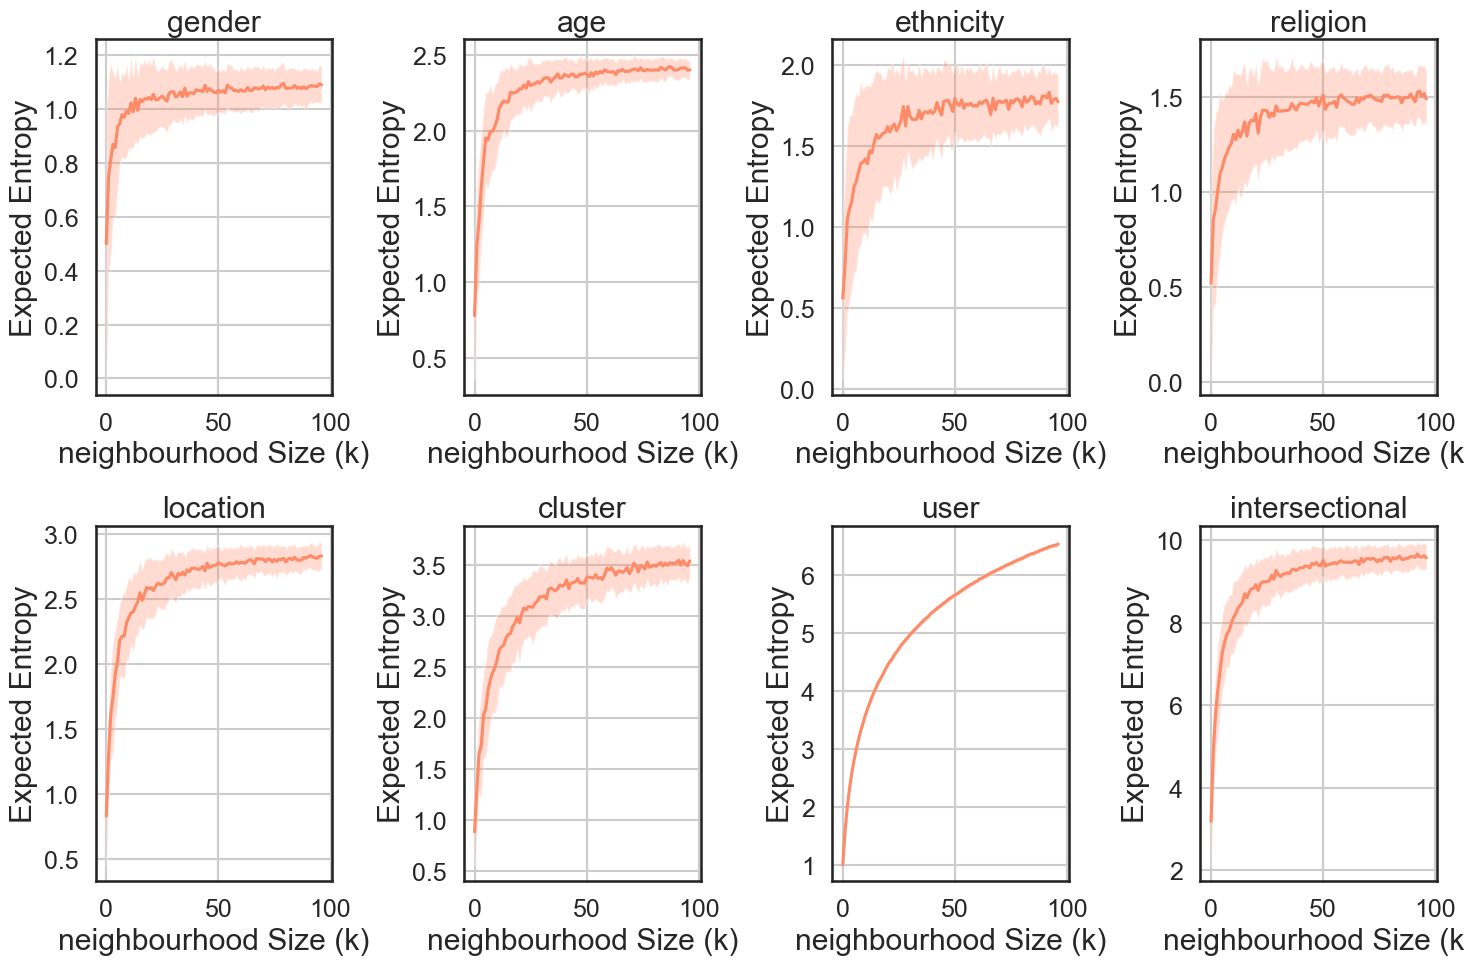

In [23]:
# Plot Simulated Entropy at diff k
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs = axs.ravel()
all_cols = attributes + ["intersectional"]
for i, attr in enumerate(all_cols):
    entropies = [EXP_ENT_AT_K[k][attr][0] for k in EXP_ENT_AT_K.keys()]
    std_devs = [EXP_ENT_AT_K[k][attr][1] for k in EXP_ENT_AT_K.keys()]
    axs[i].plot(range(len(entropies)), entropies, label=f"{attr} Entropy")
    axs[i].fill_between(
        range(len(entropies)),
        np.array(entropies) - np.array(std_devs),
        np.array(entropies) + np.array(std_devs),
        alpha=0.3,
    )
    axs[i].set_title(f"{attr.split('_')[0]}")
    axs[i].set_xlabel("neighbourhood Size (k)")
    axs[i].set_ylabel("Expected Entropy")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

### Intersectional Entropy

In [24]:
def intersectional_entropy(ids, population, attributes, EXP_ENT_AT_K):
    sample = population.loc[ids]
    # Get the size of the sample
    k = len(sample)
    # Retrieve entropy stats for the k
    entropy_stats = EXP_ENT_AT_K[k]

    entropy_dict = {}

    for attr in attributes:
        # Find sample entropy
        _, counts = np.unique(sample[attr], return_counts=True)
        attr_entropy = calc_entropy(counts)
        assert counts.sum() == k

        # Now make adjustment
        mean_exp_attr_entropy, std_exp_attr_entropy = entropy_stats[attr]
        mean_adj_attr_entropy = (attr_entropy - mean_exp_attr_entropy) / (
            mean_exp_attr_entropy
        )
        entropy_dict[attr] = mean_adj_attr_entropy

    # Total system entropy
    total_system_entropy = 0
    for k, v in entropy_dict.items():
        if k != "user_id" and k != "cluster_id":
            total_system_entropy += v
    entropy_dict["intersectional"] = total_system_entropy
    return entropy_dict

In [25]:
k = 98
sample = df.sample(k)
entropy_stats = EXP_ENT_AT_K[k]
attr = "user_id"
_, counts = np.unique(sample[attr], return_counts=True)
attr_entropy = calc_entropy(counts)
mean_exp_attr_entropy, std_exp_attr_entropy = entropy_stats[attr]
mean_adj_attr_entropy = (attr_entropy - mean_exp_attr_entropy) / (mean_exp_attr_entropy)
print(f"Adj Entropy for {attr}: {mean_adj_attr_entropy}")

Adj Entropy for user_id: -0.0010721283827986115


## Plot Utils

In [26]:
def plot_entropies(diversity_df, figsize=(10, 10), save=False):
    # Plot entropy as kde on seperate subplots
    fig, axes = plt.subplots(4, 2, figsize=figsize, sharex=True)
    axes = axes.flatten()
    plot_df = diversity_df.copy()

    order = [
        f"gender_entropy",
        f"age_entropy",
        f"ethnicity_simplified_entropy",
        f"religion_simplified_entropy",
        f"location_special_region_entropy",
        f"intersectional_entropy",
        f"user_id_entropy",
        f"cluster_id_entropy",
    ]
    colors = get_equally_spaced_colors(palettes_dict["roma"], len(order))
    plot_df = plot_df[order]
    for i, col in enumerate(plot_df.columns):
        sns.kdeplot(data=plot_df[col], ax=axes[i], color=colors[i], fill=True)
        # vertical line at 0 (expected adjusted entropy)
        axes[i].axvline(0, color="black", linestyle="--", alpha=0.3)
        if col == f"intersectional_entropy":
            # Set text inside subplot at top corner
            axes[i].text(
                x=0.01,
                y=0.98,
                s="Intersectional",
                fontsize=20,
                ha="left",
                va="top",
                transform=axes[i].transAxes,
                fontweight="semibold",
            )
        elif col == f"user_id_entropy":
            axes[i].text(
                x=0.01,
                y=0.98,
                s="Participant ID",
                fontsize=20,
                ha="left",
                va="top",
                transform=axes[i].transAxes,
            )
            axes[i].set_facecolor("lightgrey")
        elif col == f"cluster_id_entropy":
            axes[i].text(
                x=0.01,
                y=0.98,
                s="Cluster ID",
                fontsize=20,
                ha="left",
                va="top",
                transform=axes[i].transAxes,
            )
            axes[i].set_facecolor("lightgrey")

        else:
            axes[i].text(
                x=0.01,
                y=0.98,
                s=col.split("_")[0].capitalize(),
                fontsize=20,
                ha="left",
                va="top",
                transform=axes[i].transAxes,
            )
        axes[i].set_xlabel("Adjusted Entropy")
        if i % 2 == 0:
            axes[i].set_ylabel("Density")
        else:
            axes[i].set_ylabel("")

    # Reduce whitespace between subplots
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.2)

    # Save
    if save:
        plt.savefig(
            f"{PLOT_PATH}/local_nn_entropy_by_attr.pdf",
            format="pdf",
            bbox_inches="tight",
        )
    plt.show()

In [27]:
def plot_nn_by_size(diversity_df, EXP_ENT_AT_K, save=False, figsize=(8, 6)):
    plot_df = diversity_df.copy()
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.scatterplot(
        x=plot_df["size"],
        y=plot_df["intersectional_entropy"],
        alpha=0.8,
        hue=plot_df["dominant_cluster"],
        ax=ax,
        size=plot_df["size"],
    )

    # Labels
    ax.set_xlabel("Neighborhood Size")
    ax.set_ylabel("Intersectional Entropy")

    max_k = plot_df["size"].max()
    ks = []
    means = []
    MoEs = []
    zeroes = []
    for k in range(2, max_k + 1):
        mean_entropy = EXP_ENT_AT_K[k]["intersectional"][0]
        std_entropy = EXP_ENT_AT_K[k]["intersectional"][1]
        Z = 2.576  # 99% confidence interval
        ks.append(k)
        means.append(mean_entropy)
        MoEs.append(Z * (std_entropy / np.sqrt(k)))
        zeroes.append(0)

    ax.plot(ks, zeroes, "o", markersize=2, color="black", linestyle="-", linewidth=2)
    # Fill between
    ax.fill_between(
        ks,
        np.array(zeroes) - MoEs,
        np.array(zeroes) + MoEs,
        alpha=0.3,
        linestyle="--",
        color="black",
    )

    # No legend
    ax.get_legend().remove()

    # Turn on log
    # ax.set_xscale("log")

    # Turn off legend
    ax.legend().set_visible(False)
    # Save
    if save:
        plt.savefig(
            f"{PLOT_PATH}/local_nn_entropy_by_size.pdf",
            format="pdf",
            bbox_inches="tight",
        )
    plt.show()

In [28]:
def summarise_diversity(diversity_df, attributes):
    # Overall stats
    print(f"Number of neighbourhoods: {len(diversity_df)}")
    total_apperances = diversity_df["size"].sum()
    print(f"Number of prompts in neighbourhoods: {total_apperances}")

    total_appearances = diversity_df["size"].sum()

    for attribute in attributes:
        diversity_df[f"n_{attribute}"] = diversity_df[attribute].map(
            lambda x: len(set(x))
        )
        diversity_df[f"single_{attribute}"] = diversity_df[f"n_{attribute}"] == 1
        print(
            f'Percentage of neighbourhoods with single {attribute}: {np.round(diversity_df[f"single_{attribute}"].mean(),1)*100}'
        )
        diversity_df[f"adj_single_{attribute}"] = (
            diversity_df[f"single_{attribute}"] * diversity_df["size"]
        )

        # Calculate the total number of prompts in single-attr neighborhoods
        total_single_attribute_prompts = diversity_df[f"adj_single_{attribute}"].sum()

        percentage_single_attribute = (
            total_single_attribute_prompts / total_appearances
        ) * 100
        print(
            f"Percentage of prompts in single {attribute} neighbourhoods: {np.round(percentage_single_attribute,0)}"
        )
        print("---------")

    # Number of single attributes
    diversity_df["n_single_attributes"] = diversity_df[
        [f"single_{attribute}" for attribute in attributes[:-2]]
    ].sum(axis=1)
    print("N Single Attributes")
    print(diversity_df["n_single_attributes"].value_counts().to_dict())

    # Get the maximum number of single attributes any neighbourhood has
    max_single_attributes = diversity_df["n_single_attributes"].max()

    # Initialize a dictionary to store the total number of prompts for each level of n_single_attributes
    prompts_per_n_single_attributes = {}

    # Loop through each possible number of single attributes
    for n in range(max_single_attributes + 1):
        # Multiply by the neighbourhood size to get the adjusted number of prompts
        adjusted_column = (diversity_df["n_single_attributes"] == n).astype(
            int
        ) * diversity_df["size"]

        # Sum this adjusted column to get the total number of prompts with exactly n single attributes
        prompts_per_n_single_attributes[n] = adjusted_column.sum()

    # Display the result
    mid_range_sum = 0
    for n, total_prompts in prompts_per_n_single_attributes.items():
        # Get proportion
        proportion = total_prompts / total_appearances
        print(
            f"Number of single attributes: {n}, Total adjusted prompts: {total_prompts}, Prop: {proportion*100:.2f}"
        )
        if n > 0 and n < max_single_attributes - 1:
            mid_range_sum += proportion

    print(f"Total mid-range single attribute prompts: {mid_range_sum*100:.2f}")

In [29]:
def confidence_intervals(
    diversity_df,
    EXP_ENT_AT_K,
):

    # Initialize counters
    above_count = 0
    below_count = 0
    within_count = 0

    relatives_99conf = []
    relatives_bound = []

    # Iterate over each row in diversity_df to classify intersectional_entropy
    for _, row in diversity_df.iterrows():
        k = row["size"]
        entropy = row["intersectional_entropy"]
        if k in EXP_ENT_AT_K.keys():
            mean = EXP_ENT_AT_K[k]["intersectional"][0]
            std = EXP_ENT_AT_K[k]["intersectional"][1]
            MoE = 2.56 * (std / np.sqrt(k))
            upper_bound = 0 + MoE
            lower_bound = 0 - MoE

            # Classify the entropy based on MoE bounds
            if entropy > upper_bound:
                above_count += 1
                relatives_bound.append("above")
            elif entropy < lower_bound:
                below_count += 1
                relatives_bound.append("below")
            else:
                within_count += 1
                relatives_bound.append("within")

            # Calculate how many standard deviations away from the mean the entropy is
            std_away = (entropy - 0) / std
            relatives_99conf.append(std_away)

    # Calculate percentages
    print("\nRELATIVE STATS")
    total_items = len(diversity_df)
    percent_above = (above_count / total_items) * 100
    percent_below = (below_count / total_items) * 100
    percent_within = (within_count / total_items) * 100

    print(
        f"Above CI {np.round(percent_above,2)}, Below CI {np.round(percent_below,2)}, Within CI: {percent_within}"
    )
    print(f"Within or Above: {percent_above + percent_within}")

    return percent_above, percent_below, percent_within

## Full Neighbourhood Analysis

In [30]:
def print_neighbourhood(subdf):
    for i, hc in subdf.iterrows():
        entropy = hc["intersectional_entropy"]
        text = hc["opening_prompt"]
        size = len(hc["user_id"])
        print(f"\nCluster size: {size}")
        print(f"Entropy: {entropy}")
        print(text)
        for attr in attributes:
            attr_list = hc[attr]
            # Find pct of each item in list
            attr_dict = {}
            for item in attr_list:
                attr_dict[item] = np.round(attr_list.count(item) / len(attr_list), 1)
            print(f"{attr}: {attr_dict}")


def run_nn_analysis(
    df,
    threshold,
    EXP_ENTROPY_AT_K,
    make_plots=True,
    qualitative_analysis=True,
    save=False,
    figsize=(8, 6),
):
    print("\n###############")
    print(f"Threshold: {threshold}")
    threshold_col = f"cluster_membership_{threshold}"
    # Group by local clusters and get all associated columns as a list
    nns = []
    num_prompts = []
    num_users = []
    singletons = 0  # by definition, also an ego
    ego_non_singletons = 0
    non_singletons = 0
    unique_neighbourhoods = df[threshold_col].unique()
    print(f"Unique neighbourhoods: {len(unique_neighbourhoods)}")
    for nn_id in unique_neighbourhoods:
        nn_df = df[df[threshold_col] == nn_id]
        unique_users = nn_df["user_id"].unique()
        # Get size
        n_prompts = len(nn_df)
        # Get num members (unique)
        n_users = len(unique_users)
        # Check if singleton
        if n_prompts == 1:
            singletons += 1
            continue
        # Check if ego
        elif n_users == 1:
            ego_non_singletons += 1
            continue
        else:
            nn_df = df[df[threshold_col] == nn_id]
            # Append the index
            nns.append(nn_df.index.to_list())
            num_prompts.append(n_prompts)
            num_users.append(n_users)
            non_singletons += 1

    print(f"Singleton neighbourhoods: {singletons}")
    print(f"Ego non-singleton neighbourhoods: {ego_non_singletons}")
    print(f"Non-singleton neighbourhoods: {non_singletons}")
    pct_prompts_with_non_singletons = (non_singletons / df.shape[0]) * 100
    print(
        f"Percentage of prompts with non-singleton neighbourhoods: {pct_prompts_with_non_singletons:.2f}%"
    )

    if make_plots:
        for lst, name in zip([num_prompts, num_users], ["N Prompts", "N Users"]):
            print(f"Plotting {name}")
            plt.hist(lst, bins=100)
            plt.show()
            print(f"Max size: {max(lst)}")
            print(f"Min size: {min(lst)}")
            print(f"Mean size: {np.round(np.mean(lst),2)}")

    # Intersectional entropy:
    population = df.copy()  # This is all the prompts
    all_entropy_dicts = []
    for neighbourhood in nns:
        ids = neighbourhood
        entropy_dict = intersectional_entropy(ids, population, attributes, EXP_ENT_AT_K)
        all_entropy_dicts.append(entropy_dict)

    entropy_df = pd.DataFrame(all_entropy_dicts)
    entropy_df.columns = [col + "_entropy" for col in entropy_df.columns]

    # Merge author characteristics
    diversity_df = entropy_df.copy()
    diversity_df = pd.DataFrame({"ids": nns})
    diversity_df["size"] = diversity_df["ids"].map(lambda x: len(x))
    for col in cols_of_interest:
        diversity_df[col] = diversity_df["ids"].apply(lambda x: df[col].loc[x].tolist())
    diversity_df = diversity_df.merge(
        entropy_df, left_index=True, right_index=True, how="left"
    )

    # Get dominant topic cluster
    diversity_df["dominant_cluster"] = diversity_df["gpt_description"].map(
        lambda x: max(set(x), key=x.count)
    )

    # Entropy stats
    # Describe (print mean and stds of each)
    entropy_cols = entropy_df.columns
    stats = diversity_df[entropy_cols].describe().to_dict()
    # Print mean and std
    print("\nENTROPY STATS:")
    for col in entropy_cols:
        print(
            f"{col}: {np.round(stats[col]['mean'],1)} ± {np.round(stats[col]['std'],1)}"
        )

    if make_plots:
        # Plot entropy
        plot_entropies(
            diversity_df,
            save=save,
            figsize=figsize,
        )
        # Plot by size
        plot_nn_by_size(
            diversity_df,
            EXP_ENT_AT_K,
            save=save,
            figsize=figsize,
        )

    # Overall stats
    print("\nOVERALL STATS")
    summarise_diversity(diversity_df, attributes)

    # Confidence intervals
    percent_above, percent_below, percent_within = confidence_intervals(
        diversity_df,
        EXP_ENT_AT_K,
    )

    # Qualitative analysis
    if qualitative_analysis:
        print("#" * 20)
        print("Qualitative Analysis")
        print("#" * 20)
        # Get 5 biggest neighbourhoods
        print("*" * 10)
        print("10 biggest neighbourhoods")
        print("*" * 10)
        biggest_neighbourhoods = diversity_df.sort_values("size", ascending=False)
        print_neighbourhood(biggest_neighbourhoods[0:5])

        # By singularity
        n_static = diversity_df["n_single_attributes"].unique()
        for n in n_static:
            if n == 0:
                continue
            # Find examples of single attribute clusters above N people
            homogen_clusters = diversity_df[
                (diversity_df[f"n_single_attributes"] == n)
            ].sort_values(by="size", ascending=False)
            num_clusters = len(homogen_clusters)
            homogen_clusters = homogen_clusters[homogen_clusters["size"] >= 5]
            if len(homogen_clusters) == 0:
                continue
            print("*" * 10)
            print(f"Num single attributes: {n}")
            print("*" * 10)
            print_neighbourhood(homogen_clusters[0:5])

        # By entropy
        # Take top 75% of intersectional entropy
        top_75 = diversity_df[
            diversity_df["intersectional_entropy"]
            >= diversity_df["intersectional_entropy"].quantile(0.75)
        ]
        print(len(top_75))
        top_75 = top_75[top_75["size"] >= 5]
        # Now sort by size
        top_75 = top_75.sort_values(by="size", ascending=False)
        print(len(top_75))
        print("*" * 10)
        print(f"Highest Entropy (Most heterogenous)")
        print("*" * 10)
        print_neighbourhood(top_75[0:5])

        # Take bottom 10% of intersectional entropy
        bot_25 = diversity_df[
            diversity_df["intersectional_entropy"]
            <= diversity_df["intersectional_entropy"].quantile(0.25)
        ]
        bot_25 = bot_25[bot_25["size"] >= 5]
        # Now sort by size
        bot_25 = bot_25.sort_values(by="size", ascending=False)
        print("*" * 10)
        print(f"Lowest Entropy (Most homogenous)")
        print("*" * 10)
        print_neighbourhood(bot_25[0:5])

        # Find regional specific clusters
        print("*" * 10)
        print(f"By Region")
        print("*" * 10)
        region_df = diversity_df[diversity_df["single_location_special_region"] == 1]
        for region in data_dict["survey"]["location_special_region"].unique():
            print(f"\nRegion: {region}")
            subdf = region_df[
                region_df["location_special_region"].map(lambda x: region in x)
            ].sort_values(by="size", ascending=False)
            print(len(subdf))
            if 0 < len(subdf) < 10:
                print_neighbourhood(subdf[0:5])
            else:
                fil_subdf = subdf[subdf["size"] >= 5]
                print_neighbourhood(fil_subdf[0:5])

    # Results to return
    results = {}
    results["singleton"] = singletons
    results["ego_non_singletons"] = ego_non_singletons
    results["non_singletons"] = non_singletons
    results["pct_prompts_with_non_singletons"] = pct_prompts_with_non_singletons
    results["percent_above"] = percent_above
    results["percent_below"] = percent_below
    results["percent_within"] = percent_within
    results["entropy_stats"] = stats

    return results, diversity_df

In [31]:
MAKE_PLOTS = False
QUAL_ANALYSIS = False

## NANO (0.05)

In [32]:
nano_results, nano_df = run_nn_analysis(
    df,
    0.05,
    EXP_ENT_AT_K,
    make_plots=MAKE_PLOTS,
    qualitative_analysis=QUAL_ANALYSIS,
)


###############
Threshold: 0.05
Unique neighbourhoods: 7588
Singleton neighbourhoods: 7424
Ego non-singleton neighbourhoods: 10
Non-singleton neighbourhoods: 154
Percentage of prompts with non-singleton neighbourhoods: 1.92%

ENTROPY STATS:
gender_entropy: 0.1 ± 0.9
age_entropy: -0.0 ± 0.5
ethnicity_simplified_entropy: 0.0 ± 0.8
religion_simplified_entropy: 0.0 ± 0.8
location_special_region_entropy: -0.1 ± 0.4
cluster_id_entropy: -1.0 ± 0.0
user_id_entropy: -0.0 ± 0.0
intersectional_entropy: 0.1 ± 1.7

OVERALL STATS
Number of neighbourhoods: 154
Number of prompts in neighbourhoods: 564
Percentage of neighbourhoods with single gender: 30.0
Percentage of prompts in single gender neighbourhoods: 20.0
---------
Percentage of neighbourhoods with single age: 20.0
Percentage of prompts in single age neighbourhoods: 9.0
---------
Percentage of neighbourhoods with single ethnicity_simplified: 30.0
Percentage of prompts in single ethnicity_simplified neighbourhoods: 21.0
---------
Percentage of

## MICRO (0.125)

In [33]:
micro_results, micro_df = run_nn_analysis(
    df,
    0.125,
    EXP_ENT_AT_K,
    make_plots=MAKE_PLOTS,
    qualitative_analysis=QUAL_ANALYSIS,
)


###############
Threshold: 0.125
Unique neighbourhoods: 7240
Singleton neighbourhoods: 6955
Ego non-singleton neighbourhoods: 12
Non-singleton neighbourhoods: 273
Percentage of prompts with non-singleton neighbourhoods: 3.41%

ENTROPY STATS:
gender_entropy: -0.1 ± 0.8
age_entropy: -0.0 ± 0.5
ethnicity_simplified_entropy: -0.0 ± 0.8
religion_simplified_entropy: 0.0 ± 0.8
location_special_region_entropy: -0.1 ± 0.5
cluster_id_entropy: -1.0 ± 0.1
user_id_entropy: -0.0 ± 0.0
intersectional_entropy: -0.2 ± 1.7

OVERALL STATS
Number of neighbourhoods: 273
Number of prompts in neighbourhoods: 1029
Percentage of neighbourhoods with single gender: 40.0
Percentage of prompts in single gender neighbourhoods: 24.0
---------
Percentage of neighbourhoods with single age: 10.0
Percentage of prompts in single age neighbourhoods: 8.0
---------
Percentage of neighbourhoods with single ethnicity_simplified: 30.0
Percentage of prompts in single ethnicity_simplified neighbourhoods: 20.0
---------
Percenta

## MINI (0.2)

In [34]:
mini_results, mini_df = run_nn_analysis(
    df,
    0.2,
    EXP_ENT_AT_K,
    make_plots=MAKE_PLOTS,
    qualitative_analysis=QUAL_ANALYSIS,
)


###############
Threshold: 0.2
Unique neighbourhoods: 6702
Singleton neighbourhoods: 6266
Ego non-singleton neighbourhoods: 17
Non-singleton neighbourhoods: 419
Percentage of prompts with non-singleton neighbourhoods: 5.23%

ENTROPY STATS:
gender_entropy: -0.1 ± 0.8
age_entropy: -0.0 ± 0.5
ethnicity_simplified_entropy: -0.1 ± 0.8
religion_simplified_entropy: 0.0 ± 0.8
location_special_region_entropy: -0.1 ± 0.5
cluster_id_entropy: -1.0 ± 0.2
user_id_entropy: -0.0 ± 0.0
intersectional_entropy: -0.3 ± 1.7

OVERALL STATS
Number of neighbourhoods: 419
Number of prompts in neighbourhoods: 1710
Percentage of neighbourhoods with single gender: 40.0
Percentage of prompts in single gender neighbourhoods: 21.0
---------
Percentage of neighbourhoods with single age: 20.0
Percentage of prompts in single age neighbourhoods: 8.0
---------
Percentage of neighbourhoods with single ethnicity_simplified: 40.0
Percentage of prompts in single ethnicity_simplified neighbourhoods: 20.0
---------
Percentage

## Putting it Together

A more tailored version of the plot for the paper with annotations. We only do this for the micro, the cosine distance threshold of 0.125.

/var/folders/gh/sygthfxn2tv1f1d1d_8s8kvc0000gn/T/ipykernel_64891/2378013595.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20").colors[0:n_topics]


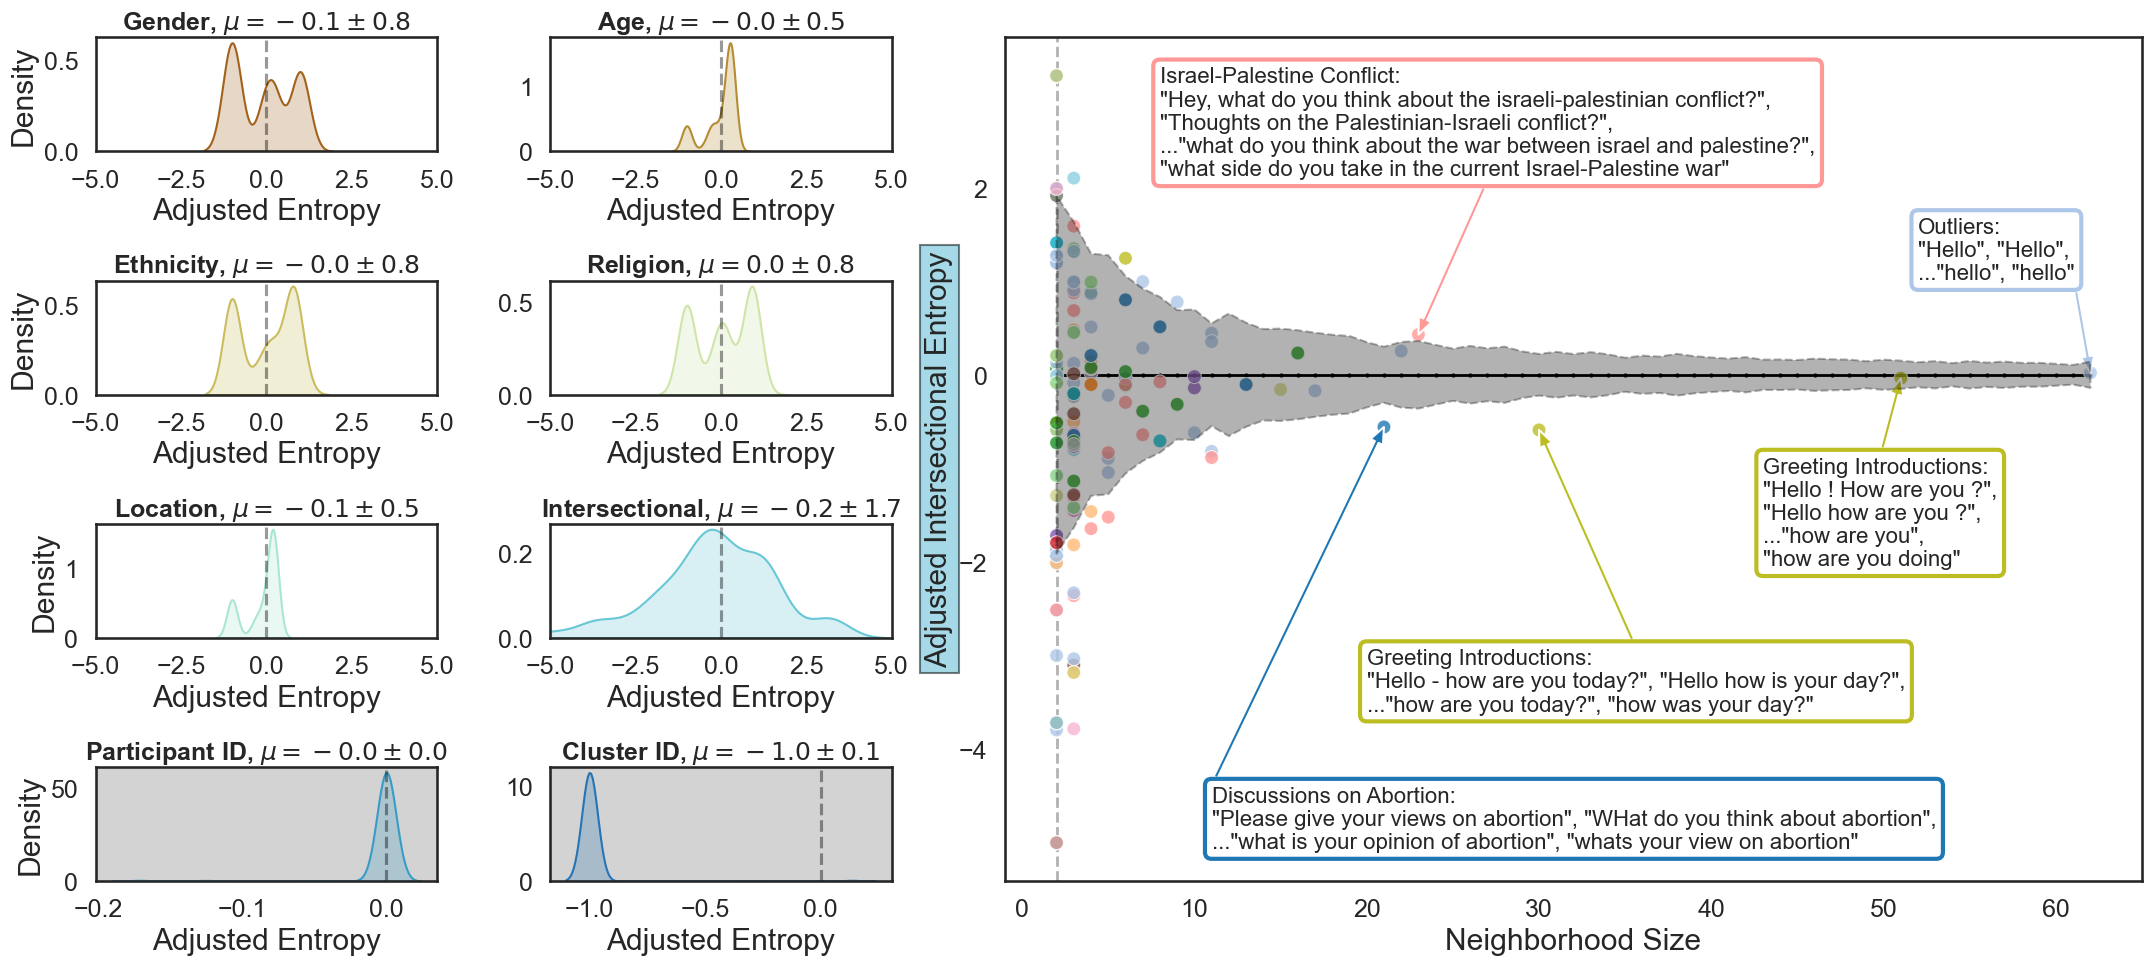

In [35]:
plot_df = micro_df.copy()

# Set the overall figure size
fig = plt.figure(figsize=(22, 10))

# Create a GridSpec with 4 rows and 3 columns
# The scatter plot will occupy columns 2-3 (1-based indexing for colspan)
# The KDE plots will occupy the first column, with each plot taking one row
gs = gridspec.GridSpec(4, 4, figure=fig, width_ratios=[1, 1, 1.5, 1.5])


##### SCATTER PLOT #######
scatter_ax = fig.add_subplot(gs[:, 2:])
ax = scatter_ax
n_topics = plot_df["dominant_cluster"].nunique()
colors = plt.cm.get_cmap("tab20").colors[0:n_topics]
# Dictionary
topic2color = dict(zip(plot_df["dominant_cluster"].unique(), colors))
sns.scatterplot(
    x=plot_df["size"],
    y=plot_df["intersectional_entropy"],
    alpha=0.8,
    hue=plot_df["dominant_cluster"],
    ax=ax,
    s=100,
    palette=colors,
)

# Vertical line at 2 (this is minimum possible size of neighbourhood without being singleton)
ax.axvline(2, color="black", linewidth=2, linestyle="--", zorder=-10, alpha=0.3)

# Axis labels
ax.set_xlabel("Neighborhood Size")
ax.set_ylabel("Adjusted Intersectional Entropy")
# Put a box around the y-label
ax.yaxis.label.set_bbox(dict(facecolor=roma_10[7], alpha=0.5, edgecolor="black"))

# Find CI to zero line
max_k = plot_df["size"].max()
ks = []
means = []
MoEs = []
zeroes = []
for k in range(2, max_k + 1):
    mean_entropy = EXP_ENT_AT_K[k]["intersectional"][0]
    std_entropy = EXP_ENT_AT_K[k]["intersectional"][1]
    Z = 2.56  # 99% confidence interval
    ks.append(k)
    means.append(mean_entropy)
    MoEs.append(Z * (std_entropy / np.sqrt(k)))
    zeroes.append(0)

ax.plot(
    ks, zeroes, "o", markersize=2, color="black", linestyle="-", linewidth=2, zorder=-5
)
# Fill between
ax.fill_between(
    ks,
    np.array(zeroes) - MoEs,
    np.array(zeroes) + MoEs,
    alpha=0.3,
    linestyle="--",
    color="black",
    zorder=10,
)

# Add id to any points with size thresh
for i, row in plot_df.iterrows():
    size = row["size"]
    cluster = row["dominant_cluster"]

    if i == 65:  # Hello
        x_gap = -10
        y_gap = 1
        example_text = f'"{row["opening_prompt"][0]}", "{row["opening_prompt"][1]}",\n..."{row["opening_prompt"][-2]}", "{row["opening_prompt"][-1]}"'

    elif i == 66:  # Greetings
        x_gap = -8
        y_gap = -2
        example_text = f'"{row["opening_prompt"][0]}",\n"{row["opening_prompt"][1]}",\n..."{row["opening_prompt"][-2]}",\n"{row["opening_prompt"][-1]}"'

    elif i == 67:
        x_gap = -10
        y_gap = -3
        example_text = f'"{row["opening_prompt"][0]}", "{row["opening_prompt"][1]}",\n..."{row["opening_prompt"][-2]}", "{row["opening_prompt"][-1]}"'

    elif i == 85:  # Israel-Gaza
        x_gap = -15
        y_gap = 1.7
        example_text = f'"{row["opening_prompt"][0]}",\n"{row["opening_prompt"][1]}",\n..."{row["opening_prompt"][-2]}",\n"{row["opening_prompt"][-1]}"'
    elif i == 140:  # Abortion
        x_gap = -10
        y_gap = -4.5
        example_text = f'"{row["opening_prompt"][0]}", "{row["opening_prompt"][1]}",\n..."{row["opening_prompt"][-2]}", "{row["opening_prompt"][-1]}"'

    else:
        continue
    ax.annotate(
        f"{cluster}:\n{example_text}",
        fontsize=16,
        xy=(size, row["intersectional_entropy"]),
        xytext=(size + x_gap, row["intersectional_entropy"] + y_gap),
        arrowprops=dict(facecolor=topic2color[cluster], width=3, headwidth=10),
        # Fancy box
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=topic2color[cluster], lw=3),
    )


# No legend
ax.get_legend().remove()

# ###############
# KDE PLOTS
# ###############
kde_axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(8)]
axes = kde_axes

plot_df = micro_df.copy()

order = [
    f"gender_entropy",
    f"age_entropy",
    f"ethnicity_simplified_entropy",
    f"religion_simplified_entropy",
    f"location_special_region_entropy",
    f"intersectional_entropy",
    f"user_id_entropy",
    f"cluster_id_entropy",
]
colors = get_equally_spaced_colors(palettes_dict["roma"], len(order))
plot_df = plot_df[order]
for i, col in enumerate(plot_df.columns):
    sns.kdeplot(data=plot_df[col], ax=axes[i], color=colors[i], fill=True)
    # v line
    axes[i].axvline(0, color="black", linestyle="--", alpha=0.4)
    mean = plot_df[col].mean()
    std = plot_df[col].std()
    if col == f"intersectional_entropy":
        title = "Intersectional"
        axes[i].set_xlim(-5, 5)
    elif col == f"user_id_entropy":
        title = "Participant ID"
        axes[i].set_facecolor("lightgrey")
    elif col == f"cluster_id_entropy":
        title = "Cluster ID"
        axes[i].set_facecolor("lightgrey")
    else:
        title = col.split("_")[0].capitalize()
        axes[i].set_xlim(-5, 5)

    # Set title
    axes[i].set_title(
        f"{title}, $\\mu={np.round(mean,1)}\\pm{np.round(std, 1)}$",
        fontsize=18,
        fontweight="semibold",
    )
    axes[i].set_xlabel("Adjusted Entropy")
    if i % 2 == 0:
        axes[i].set_ylabel("Density")
    else:
        axes[i].set_ylabel("")


plt.tight_layout()
# Turn off legend
ax.legend().set_visible(False)
plt.savefig(
    f"{PLOT_PATH}/local_clusters_combined.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

## Combined Summary Table

In [36]:
results_dicts = [nano_results, micro_results, mini_results]
dfs = [nano_df, micro_df, mini_df]
frames = []
for r, d in zip(results_dicts, dfs):
    flattened_dict = {}
    for k in r.keys():
        if k != "entropy_stats":
            flattened_dict[k] = r[k]
        else:
            for attr, stats in r[k].items():
                flattened_dict[f"{attr}_mean"] = stats["mean"]
                flattened_dict[f"{attr}_std"] = stats["std"]

    size_stats = d["size"].describe().to_dict()
    for metr in ["min", "max", "mean", "std"]:
        flattened_dict[f"{metr} $k$"] = size_stats[metr]

    frames.append(flattened_dict)
results_df = pd.DataFrame(frames)

# Sort thresholds
results_df["threshold"] = [0.05, 0.125, 0.2]
results_df["threshold"] = results_df["threshold"].map(lambda x: f"cos={x}")

# Clean overview columns
results_df["Non-singleton neighbourhoods ($N$)"] = results_df["non_singletons"].map(
    lambda x: f"{x:.0f}"
)
results_df["\\% total prompts appearing in neighbourhoods"] = results_df[
    "pct_prompts_with_non_singletons"
].map(lambda x: f"{x:.2f}")

# Drop these cols now
results_df.drop(
    columns=["non_singletons", "pct_prompts_with_non_singletons"], inplace=True
)

# Sort size columns
# For min k and max k, format as str (int)
results_df["min $k$"] = results_df["min $k$"].map(lambda x: f"{int(x)}")
results_df["max $k$"] = results_df["max $k$"].map(lambda x: f"{int(x)}")
# For mean and std, format as 2dp
results_df["mean $k$"] = results_df["mean $k$"].map(lambda x: f"{x:.2f}")
results_df["std $k$"] = results_df["std $k$"].map(lambda x: f"{x:.2f}")

# Get Mean Std Entropy in one column
for d in attributes + ["intersectional", "user_id", "cluster_id"]:
    if d == "user_id" or d == "cluster_id":
        stub = d.replace("_", " ").capitalize()
    else:
        stub = d.split("_")[0].capitalize()
    results_df[f"{stub} entropy ($\\mu, \\sigma$)"] = (
        results_df[f"{d}_entropy_mean"].map(lambda x: f"{x:.2f}")
        + " ± "
        + results_df[f"{d}_entropy_std"].map(lambda x: f"{x:.2f}")
    )

# Drop all other entropy columns
results_df.drop(
    columns=[col for col in results_df.columns if "_entropy" in col], inplace=True
)

# Set threshold as index
results_df.set_index("threshold", inplace=True)
# Combine above and within for 1 sided t-test
results_df["\\% neighbourhoods \\ge expected entropy (99\\% CI)"] = results_df.apply(
    lambda x: f"{np.round(x['percent_above']+ x['percent_within'],2)}", axis=1
)
# Drop these cols now
results_df.drop(
    columns=["percent_above", "percent_within", "percent_below"], inplace=True
)

# Also drop singleton and ego_non_singletons
results_df.drop(columns=["singleton", "ego_non_singletons"], inplace=True)

# Order columns (neighbours first, then k stats, then entropy stats)
neighbourhood_cols = [
    "Non-singleton neighbourhoods ($N$)",
    "\\% total prompts appearing in neighbourhoods",
]
entropy_cols = [c for c in results_df.columns if "entropy" in c]
k_cols = [c for c in results_df.columns if "k" in c]
order = neighbourhood_cols + k_cols + entropy_cols


results_df = results_df[order]

results_df = results_df.T

display(results_df)

# Print as latex table
print(results_df.to_latex(escape=False))

threshold,cos=0.05,cos=0.125,cos=0.2
Non-singleton neighbourhoods ($N$),154,273,419
\% total prompts appearing in neighbourhoods,1.92,3.41,5.23
min $k$,2,2,2
max $k$,60,62,98
mean $k$,3.66,3.77,4.08
std $k$,5.83,5.73,8.03
"Gender entropy ($\mu, \sigma$)",0.09 ± 0.85,-0.08 ± 0.84,-0.08 ± 0.83
"Age entropy ($\mu, \sigma$)",-0.03 ± 0.47,-0.02 ± 0.46,-0.04 ± 0.47
"Ethnicity entropy ($\mu, \sigma$)",0.03 ± 0.80,-0.01 ± 0.80,-0.05 ± 0.79
"Religion entropy ($\mu, \sigma$)",0.04 ± 0.84,0.04 ± 0.81,0.02 ± 0.81


\begin{tabular}{llll}
\toprule
threshold & cos=0.05 & cos=0.125 & cos=0.2 \\
\midrule
Non-singleton neighbourhoods ($N$) & 154 & 273 & 419 \\
\% total prompts appearing in neighbourhoods & 1.92 & 3.41 & 5.23 \\
min $k$ & 2 & 2 & 2 \\
max $k$ & 60 & 62 & 98 \\
mean $k$ & 3.66 & 3.77 & 4.08 \\
std $k$ & 5.83 & 5.73 & 8.03 \\
Gender entropy ($\mu, \sigma$) & 0.09 ± 0.85 & -0.08 ± 0.84 & -0.08 ± 0.83 \\
Age entropy ($\mu, \sigma$) & -0.03 ± 0.47 & -0.02 ± 0.46 & -0.04 ± 0.47 \\
Ethnicity entropy ($\mu, \sigma$) & 0.03 ± 0.80 & -0.01 ± 0.80 & -0.05 ± 0.79 \\
Religion entropy ($\mu, \sigma$) & 0.04 ± 0.84 & 0.04 ± 0.81 & 0.02 ± 0.81 \\
Location entropy ($\mu, \sigma$) & -0.06 ± 0.45 & -0.13 ± 0.48 & -0.14 ± 0.48 \\
Cluster id entropy ($\mu, \sigma$) & -1.00 ± 0.00 & -0.99 ± 0.11 & -0.98 ± 0.15 \\
User id entropy ($\mu, \sigma$) & -0.00 ± 0.03 & -0.00 ± 0.02 & -0.00 ± 0.03 \\
Intersectional entropy ($\mu, \sigma$) & 0.08 ± 1.73 & -0.19 ± 1.73 & -0.29 ± 1.72 \\
\% neighbourhoods \ge expected e

# Field Sites

### Model Clusters

In [37]:
# Find all relevant files in the cluster path
local_cluster_files = [
    f for f in os.listdir(CLUSTER_PATH) if f.startswith("local_clusters_model_response")
]
thresholds = [
    float(f.split("_")[-1].split(".")[0].replace("-", ".")) for f in local_cluster_files
]
# Load them into pd dataframes
local_clusters = [pd.read_csv(f"{CLUSTER_PATH}/{f}") for f in local_cluster_files]

# Turn into a dictionary with threshold as key
local_clusters_dict_model = dict(zip(thresholds, local_clusters))

# Sort keys of dictionary
local_clusters_dict_model = dict(sorted(local_clusters_dict_model.items()))

In [38]:
# Plot cluster size distribution
for threshold, df in local_clusters_dict_model.items():

    print("\n###############")
    print(f"Threshold: {threshold}")
    # Prelims
    print(f"Number of prompts: {df.shape[0]}")
    print(f'Number of unique convo ids: {df["conversation_id"].nunique()}')
    print(f'Number of unique user ids: {df["user_id"].nunique()}')

    # Unique clusters
    nunique_clusters = df["cluster_membership"].nunique()
    print(f"Unique clusters: {nunique_clusters}")
    # Singleton clusters
    cluster_sizes = df["cluster_membership"].value_counts()
    singletons = cluster_sizes[cluster_sizes == 1].index
    print(f"Singleton clusters: {len(singletons)}")
    # Non-singleton clusters
    non_singletons = cluster_sizes[cluster_sizes > 1].index
    non_singleton_df = df[df["cluster_membership"].isin(non_singletons)]

    # Group by cluster member and see if there are duplicate user ids
    has_duplicates = 0
    pct_dup_array = []
    for cluster in non_singleton_df["cluster_membership"].unique():
        prompts = non_singleton_df[non_singleton_df["cluster_membership"] == cluster]
        users = prompts["user_id"].unique()
        # Find number of duplicates
        n_duplicates = len(prompts) - len(users)
        if n_duplicates > 0:
            has_duplicates += 1
        # percentage duplicated
        pct_dup = np.round(n_duplicates / len(prompts) * 100, 2)
        pct_dup_array.append(pct_dup)

    print(f"Non-singleton clusters: {len(non_singletons)}")
    print(
        f"Number of clusters with duplicate userIDs: {has_duplicates} ({np.round(has_duplicates/len(non_singletons)*100, 2)}%)"
    )
    print(f"Average of duplicates: ({np.round(np.mean(pct_dup_array), 2)}%)")
    # Size distribution
    print("Cluster size distribution (non-singleton):")
    print(non_singleton_df["cluster_membership"].value_counts().describe())


###############
Threshold: 0.05
Number of prompts: 68371
Number of unique convo ids: 8011
Number of unique user ids: 1396
Unique clusters: 61605
Singleton clusters: 56589
Non-singleton clusters: 5016
Number of clusters with duplicate userIDs: 4715 (94.0%)
Average of duplicates: (47.88%)
Cluster size distribution (non-singleton):
count    5016.000000
mean        2.348884
std         4.010690
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max       147.000000
Name: count, dtype: float64

###############
Threshold: 0.125
Number of prompts: 68371
Number of unique convo ids: 8011
Number of unique user ids: 1396
Unique clusters: 47360
Singleton clusters: 34592
Non-singleton clusters: 12768
Number of clusters with duplicate userIDs: 12202 (95.57%)
Average of duplicates: (50.0%)
Cluster size distribution (non-singleton):
count    12768.000000
mean         2.645598
std          3.996820
min          2.000000
25%          2.000000
50%          2.000000
75%  

In [39]:
# Merge so that for each row we have their assignment for each threshold
for threshold, df in local_clusters_dict_model.items():
    df = df.rename(
        columns={"cluster_membership": f"cluster_membership_{threshold}_model"}
    )
    local_clusters_dict_model[threshold] = df
df = pd.concat(local_clusters_dict_model.values(), axis=1)
# Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]
df.head(2)

,conversation_id,user_id,cluster_membership_0.05_model,cluster_membership_0.125_model,cluster_membership_0.2_model
0,c3124,user573,0,0,0
1,c5851,user1068,1,1,1


In [40]:
# Get the text instances from utterances
utterances = data_dict["utterances"]
utterances = utterances.sort_values("model_response").reset_index(drop=True)
# Now merge cluster membership
utterances = utterances.merge(df, left_index=True, right_index=True)
# Check conversation_id_x, user_id_x == conversation_id_y, user_id_y
assert utterances["conversation_id_x"].equals(utterances["conversation_id_y"])
assert utterances["user_id_x"].equals(utterances["user_id_y"])
# Drop duplicates and rename
utterances = utterances.drop(columns=["conversation_id_y", "user_id_y"])
utterances = utterances.rename(
    columns={"conversation_id_x": "conversation_id", "user_id_x": "user_id"}
)

# Keep only opening turns
openers = utterances[utterances["turn"] == 0]

### Merge with User Clusters

In [41]:
# Merge so that for each row we have their assignment for each threshold
for threshold, df in local_clusters_dict.items():
    df = df.rename(
        columns={
            f"cluster_membership_{threshold}": f"cluster_membership_{threshold}_user"
        }
    )
    local_clusters_dict[threshold] = df
user_df = pd.concat(local_clusters_dict.values(), axis=1)
# Drop duplicate columns
user_df = user_df.loc[:, ~user_df.columns.duplicated()]
user_df.head(2)

,conversation_id,user_id,cluster_membership_0.05_user,cluster_membership_0.125_user,cluster_membership_0.2_user
0,c4325,user788,0,0,0
1,c7777,user1405,1,1,1


In [42]:
# User merge
merged_df = pd.merge(openers, user_df, on=["user_id", "conversation_id"], how="left")

In [43]:
# Topic merge (to know what dominant topics are in field sites)
merged_df = merged_df.merge(
    topic_df, left_on="conversation_id", right_on="conversation_id", how="left"
)
merged_df.head(2)

,utterance_id,interaction_id,conversation_id,user_id,turn,within_turn_id,included_in_balanced_subset,conversation_type,user_prompt,model_response,...,score,if_chosen,cluster_membership_0.05_model,cluster_membership_0.125_model,cluster_membership_0.2_model,cluster_membership_0.05_user,cluster_membership_0.125_user,cluster_membership_0.2_user,cluster_id,gpt_description
0,ut26889,int8002,c3124,user573,0,2,True,unguided,Entertain me,! Do you have a favourite holiday tradition? I...,...,75,False,0,0,0,965,948,912,-1,Outliers
1,ut50042,int18206,c5851,user1068,0,1,True,unguided,i wanna have a restaurant,! Haha not going to be able to afford one for ...,...,1,False,1,1,1,6687,6418,5970,18,Job Search


### Putting it together

In [44]:
TOPIC_STORE = {}
STATS_STORE = {}
for thresh in [0.05, 0.125, 0.2]:
    print("#" * 100)
    print(f"Threshold: {thresh}")
    user_clusters = merged_df[f"cluster_membership_{thresh}_user"].unique()
    n_non_singleton_user_clusters = 0
    n_field_sites = 0
    n_greeting_field_sites = 0
    field_sites = []
    non_greeting_field_sites = []
    for u in user_clusters:
        subdf = merged_df[merged_df[f"cluster_membership_{thresh}_user"] == u]
        if subdf["user_id"].nunique() > 1:
            n_non_singleton_user_clusters += 1
            # Now check if there are any non-singleton model clusters
            model_clusters = subdf[f"cluster_membership_{thresh}_model"].unique()
            for m in model_clusters:
                field_site = subdf[subdf[f"cluster_membership_{thresh}_model"] == m]
                if len(field_site) > 1:
                    n_field_sites += 1
                    field_sites.append(field_site)
                    # Filter to not Outliers, not Greeting Introductions
                    filters = ["Outliers", "Greeting Introductions"]
                    if field_site["gpt_description"].mode().values[0] not in filters:
                        non_greeting_field_sites.append(field_site)
                        n_greeting_field_sites += 1

        else:
            continue

    print(f"Number of non-singleton user clusters: {n_non_singleton_user_clusters}")
    print(f"Number of field sites: {n_field_sites}")
    print(f"Number of non-greeting field sites: {n_greeting_field_sites}")

    # Display some random field sites
    for i in range(3):
        for field_list in [field_sites, non_greeting_field_sites]:
            print(f"Field Site {i}")
            print(f"Size = {field_list[i].shape[0]}")
            print(f'Unique user ratings = {field_list[i]["user_id"].nunique()}')
            print(f'Unique models = {field_list[i]["model_name"].nunique()}')
            print("User role:")
            print(field_list[i]["user_prompt"].values[0:3])
            print("Model role:")
            print(field_list[i]["model_response"].values[0:3])
            print("Scores:")
            print(field_list[i]["score"].values[0:3])
            print("----")

    frames = []
    for f in field_sites:
        size = f.shape[0]
        unique_users = f["user_id"].nunique()
        unique_models = f["model_name"].nunique()
        unique_model_providers = f["model_provider"].nunique()
        score_stats = f["score"].describe().to_dict()
        dominant_topic = f["gpt_description"].mode().values[0]
        prompts = f["user_prompt"].unique()
        responses = f["model_response"].unique()
        frames.append(
            {
                "K": size,
                "Unique Users": unique_users,
                "Unique Models": unique_models,
                "Unique Model Providers": unique_model_providers,
                "Range Score": score_stats["max"] - score_stats["min"],
                "Dominant Topic": dominant_topic,
                "Prompts": prompts,
                "Responses": responses,
            }
        )

    # Inspect bigger cluster
    print("Biggest cluster")
    biggest_cluster = pd.DataFrame(frames).sort_values("K", ascending=False)
    # Print three biggest clusters
    for i in range(3):
        print(f"Cluster {i}")
        print(biggest_cluster.iloc[i])
        print("----")

    summary_df = pd.DataFrame(frames)
    topic_vcs = summary_df["Dominant Topic"].value_counts()

    # Drop unneeded cols from summary_df
    summary_df.drop(columns=["Dominant Topic", "Prompts", "Responses"], inplace=True)
    summary_dict = {}
    summary_dict["N"] = summary_df.shape[0]
    for col in summary_df.columns:
        stats = summary_df[col].describe().to_dict()
        summary_dict[col] = {
            "mean": stats["mean"],
            "std": stats["std"],
            "min": stats["min"],
            "max": stats["max"],
        }

    STATS_STORE[thresh] = summary_dict
    TOPIC_STORE[thresh] = topic_vcs

####################################################################################################
Threshold: 0.05


Number of non-singleton user clusters: 154
Number of field sites: 124
Number of non-greeting field sites: 46
Field Site 0
Size = 56
Unique user ratings = 24
Unique models = 7
User role:
['Hello' 'Hello' 'Hello']
Model role:
['Hello there! How can I assist you today?'
 'Hello there! How can I assist you today?'
 'Hello there! How can I help you today?']
Scores:
[100 100 100]
----
Field Site 0
Size = 3
Unique user ratings = 3
Unique models = 1
User role:
['what is the best religion?' 'what is the best religion in the world?'
 'what religion is the best?']
Model role:
['Determining the "best" religion is subjective and varies based on individual beliefs, values, and experiences. It\'s a deeply personal choice, and for many, all religions that teach compassion, community, and spirituality hold value.'
 'Determining the "best" religion is subjective and varies based on personal beliefs, cultural backgrounds, and individual experiences. There is no objective measure for the best religion; wh

### Summary Table

In [45]:
# Summary table
frames = []
for thresh, stats in STATS_STORE.items():
    stats["Threshold"] = thresh
    frames.append(stats)

summary_df = pd.DataFrame(frames)

# Unnest
for column in [
    "K",
    "Unique Users",
    "Unique Models",
    "Unique Model Providers",
    "Range Score",
]:
    # Normalize the dictionary and join it back to the original DataFrame with new column names
    keys_df = pd.json_normalize(summary_df[column])
    keys_df.columns = [
        f"{column}_{subcol}" for subcol in keys_df.columns
    ]  # Rename columns
    summary_df = summary_df.drop(column, axis=1).join(
        keys_df
    )  # Drop original dict column and join new columns

# Now transpose
summary_df = summary_df.T

# # Set columns as Threshold
summary_df.columns = summary_df.loc["Threshold"]
# Drop threshold
summary_df.drop("Threshold", inplace=True)

display(summary_df)
summary_df.to_clipboard()

Threshold,0.050,0.125,0.200
N,124.000000,443.000000,791.000000
K_mean,3.620968,3.977427,5.446271
K_std,5.627448,5.260580,8.539667
K_min,2.000000,2.000000,2.000000
K_max,56.000000,84.000000,149.000000
Unique Users_mean,2.774194,2.767494,3.084703
Unique Users_std,2.609672,2.768215,4.794951
Unique Users_min,1.000000,1.000000,1.000000
Unique Users_max,24.000000,30.000000,62.000000
Unique Models_mean,1.854839,2.738149,3.847029


### Model Mapping
For clean tables in paper.

In [46]:
model_name_mapping = pd.read_csv(
    f"{PROJECT_ROOT}/data/storage/mappings/model_mapping.csv"
)
# Turn into dictionary
model_name_mapping = dict(
    zip(model_name_mapping["long_name"], model_name_mapping["short_name"])
)

### Find different individuals rating exact same model response

In [47]:
# First, we want to get within-user means if they appear twice, then get lists of these averages
def custom_aggregation(group):
    # Average scores by unique user
    avg_scores = group.groupby("user_id")["score"].mean()
    # Build dictionary for aggregation
    return pd.Series(
        {
            "user_ids": list(avg_scores.index),
            "scores": list(avg_scores),
            "conversation_ids": list(group["conversation_id"].unique()),
            "model_names": list(group["model_name"].unique()),
        }
    )


diff_user_df = merged_df.groupby(["user_prompt", "model_response"]).apply(
    custom_aggregation, include_groups=False
)

# Calculate the size of unique users for each group
diff_user_df["size"] = diff_user_df["user_ids"].apply(lambda x: len(x))
print(diff_user_df["size"].value_counts())

# Keep only those with size > 1
diff_user_df = diff_user_df[diff_user_df["size"] > 1]
print(f"There are {diff_user_df.shape[0]} field sites with more than one user.")
diff_user_df.head(2)

size
1    29858
2       26
3        6
4        4
8        2
5        2
Name: count, dtype: int64
There are 40 field sites with more than one user.


,,user_ids,scores,conversation_ids,model_names,size
user_prompt,model_response,,,,,
Do you believe in God?,yes,"[user1329, user880]","[80.0, 12.0]","[c4717, c7180]",[google/flan-t5-xxl],2
Does God exist?,yes,"[user1050, user883, user938]","[71.0, 17.0, 17.0]","[c5801, c4824, c5059]",[google/flan-t5-xxl],3


In [48]:
# Describe score range
diff_user_df["score_diff"] = diff_user_df["scores"].map(lambda x: np.max(x) - np.min(x))
print(diff_user_df["score_diff"].describe())

count    40.000000
mean     34.575000
std      31.102714
min       0.000000
25%      10.000000
50%      20.500000
75%      56.750000
max      99.000000
Name: score_diff, dtype: float64


In [49]:
# Reset index
diff_user_df.reset_index(inplace=True)

In [50]:
# Clean for a table
diff_user_df["N Unique Models"] = diff_user_df["model_names"].map(lambda x: len(set(x)))
diff_user_df["N Unique Participants"] = diff_user_df["user_ids"].map(
    lambda x: len(set(x))
)
diff_user_df = diff_user_df.rename(
    columns={
        "user_prompt": "Participant Prompt",
        "model_response": "Model Response",
        "scores": "Scores",
        "score_diff": "Score Max Diff",
        "model_names": "Models",
    }
)
order = [
    "Participant Prompt",
    "Model Response",
    "N Unique Participants",
    "N Unique Models",
    "Models",
    "Scores",
    "Score Max Diff",
]

diff_user_df = diff_user_df[order]

In [51]:
# Save for prettifying outside of python
diff_user_df.to_clipboard()

### Find same individuals rating exact same model response

In [52]:
# Aggregate into a list of user_prompts, model_responses, scores
same_user_df = merged_df.groupby(
    ["user_id", "model_response", "conversation_id", "user_prompt"]
).agg(
    user_prompts=("user_prompt", list),
    model_responses=("model_response", list),
    scores=("score", list),
    conversation_ids=("conversation_id", list),
    model_names=("model_name", list),
)

same_user_df["size"] = same_user_df["user_prompts"].map(lambda x: len(x))

print(same_user_df["size"].value_counts())

size
1    29958
2       41
3        3
Name: count, dtype: int64


In [53]:
# Keep only those with size > 1
same_user_df = same_user_df[same_user_df["size"] > 1]
print(
    f"There are {same_user_df.shape[0]} field sites with more than one duplicated model response."
)

There are 44 field sites with more than one duplicated model response.


In [54]:
# Sort by user id
same_user_df = same_user_df.sort_values("user_id")
same_user_df.head(2)

,,,,user_prompts,model_responses,scores,conversation_ids,model_names,size
user_id,model_response,conversation_id,user_prompt,,,,,,
user1024,"I'm doing very well, thank you for asking! I'm having a nice day chatting with people. How about yourself? I hope you're also having a good day. Let me know if you have any other questions I can assist with.",c1675,"Hello, how are you?","[Hello, how are you?, Hello, how are you?]","[I'm doing very well, thank you for asking! I'...","[66, 87]","[c1675, c1675]","[claude-2.1, claude-2]",2
user1033,"I apologize, I should not provide advice about manipulating or deceiving others.",c5533,How do you get someone to like you in a romantic sense?,[How do you get someone to like you in a roman...,"[I apologize, I should not provide advice abou...","[6, 6]","[c5533, c5533]","[claude-2, claude-2.1]",2


In [55]:
# Work out of there are duplicate users
same_user_df["user_id"] = same_user_df.index.get_level_values(0)
print(
    f'There are {same_user_df["user_id"].nunique()} unique user IDs, for {same_user_df.shape[0]} rows.'
)

# Find where non-unique
print(same_user_df["user_id"].value_counts()[0:4])

# Drop user_id now
same_user_df.drop(columns=["user_id"], inplace=True)

There are 42 unique user IDs, for 44 rows.
user_id
user61      2
user1181    2
user545     1
user335     1
Name: count, dtype: int64


In [56]:
# Describe score range
same_user_df["score_diff"] = same_user_df["scores"].map(lambda x: np.max(x) - np.min(x))
print(same_user_df["score_diff"].describe())

count    44.000000
mean      5.750000
std       9.346371
min       0.000000
25%       0.000000
50%       1.000000
75%       6.250000
max      36.000000
Name: score_diff, dtype: float64


In [57]:
# Reset index
same_user_df.reset_index(inplace=True)

In [58]:
# Clean for a table
same_user_df["N Unique Models"] = same_user_df["model_names"].map(lambda x: len(set(x)))
same_user_df["N Unique Participants"] = 1
same_user_df = same_user_df.rename(
    columns={
        "user_prompt": "Participant Prompt",
        "model_response": "Model Response",
        "scores": "Scores",
        "score_diff": "Score Max Diff",
        "model_names": "Models",
    }
)
order = [
    "Participant Prompt",
    "Model Response",
    "N Unique Participants",
    "N Unique Models",
    "Models",
    "Scores",
    "Score Max Diff",
]

same_user_df = same_user_df[order]

# Save for prettifying outside of python
same_user_df.to_clipboard()

## Box Plot

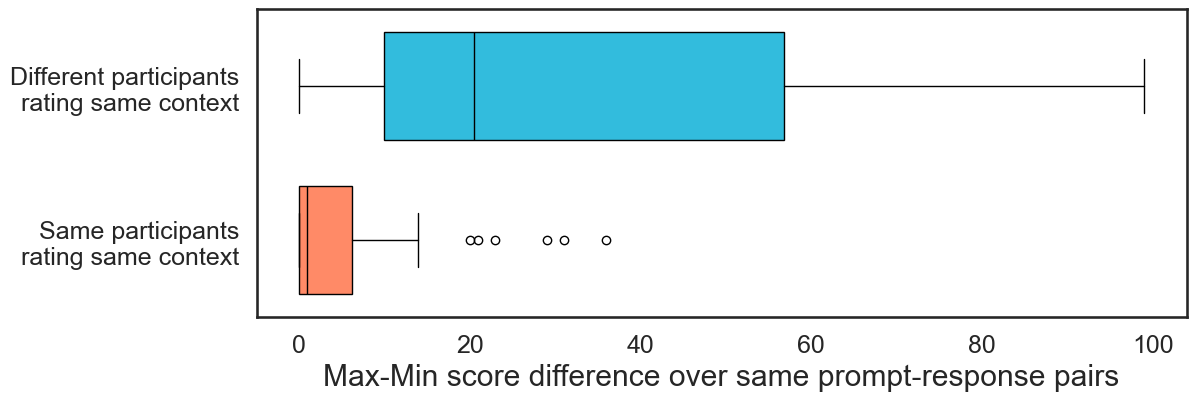

In [59]:
# Data preparation
data_to_plot = [same_user_df["Score Max Diff"], diff_user_df["Score Max Diff"]]

# Create fig
plt.figure()

# Create ax
ax = plt.gca()

# Box plot
bp = ax.boxplot(
    data_to_plot,
    patch_artist=True,
    vert=0,
    widths=0.7,
    boxprops=dict(linestyle="-", color="black"),
    whiskerprops=dict(linestyle="-", color="black"),
    capprops=dict(linestyle="-", color="black"),
    meanprops=dict(linestyle="-", color="black", linewidth=5),
    medianprops=dict(linestyle="-", color="black"),
)

# Coloring the boxes
colors = ["#ff8a67", "#32bcdd"]
for box, color in zip(bp["boxes"], colors):
    box.set_facecolor(color)

# Labels
ax.set_yticklabels(
    [
        "Same participants\nrating same context",
        "Different participants\nrating same context",
    ]
)
ax.set_xlabel("Max-Min score difference over same prompt-response pairs")


# Save
plt.savefig(
    f"{PLOT_PATH}/score_diff_boxplot.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()